In [1]:
import cv2
import pytesseract
#import csv
import numpy as np
import pandas as pd
from ultralytics import YOLO
import textract
#from PIL import Image
import matplotlib.pyplot as plt
import keras_ocr
import Levenshtein
from skimage.filters import threshold_local

In [40]:
import easyocr
text_reader = easyocr.Reader(['en']) #Initialzing the ocr
config = f'--psm 7'
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\Flam\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\Flam\.keras-ocr\crnn_kurapan.h5


In [3]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255
#function to enhance the contrast of image for better ocr result
def enhance(im):
    img1 = cv2.imread(im)
    img = bw_scanner(img1)
    # converting to LAB color space
    img=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(9,9))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    #result = np.hstack((img, enhanced_img))
    #cv2.imshow('Result', result)
    #cv2.waitKey(0)
    return enhanced_img

In [4]:
# extracting bounding boxes cordinates and their labels
def boxes_labels(results,x,y,h,w,c):
    bbox=results[0].boxes.boxes
    bbox=bbox.cpu().numpy()
    boxes=results[0].boxes.xyxy
    for i,box in enumerate(boxes):
        box=box.cpu().numpy()
        print("fragment ",i," :",box)
        x.append(int(box[0]))
        y.append(int(box[1]))
        h.append(int(box[3]-y[i]))
        w.append(int(box[2]-x[i]))
        c.append(bbox[i][5])

In [5]:
#storing ROIs in a liste
def crop_image(x,y,h,w):
    cropped=[]
    for (X,Y,H,W) in zip(x,y,h,w):
        cropped.append(img[Y:Y+H, X:X+W])
    print("cropped images: ",len(cropped))
    return (cropped)

In [6]:
#to avoid the presence of multi instance from classes
def singilarity(cropped,c,classes,images):
   # images=[]
    for (img,C) in zip(cropped,c):
        try:
            i=classes.index(C)
        except:
            i=-1
        if i<0 :
            classes.append(C)
            images.append(img)
        else :
            if len(img)>len(images[i]) :
                images[i]=img
    print('number of images:',len(images),'number of classes',len(classes))
            

In [7]:
#cleaning strings
def strip_string(my_string):
    replacements = [('!', ''), ('?', ''),('|',''),("[",""),("]",""),(" ",""),('\\',""),('\r',''),('\'',''),('.',''),('',''),("\u200f",""),("\u200e",""),("{",""),("}",""),("%",""),("~",""),(",","."),(':','.'),(";","."),('°',''),('+',''),('(',''),(')','')]
    for char, replacement in replacements:
        if char in my_string:
            my_string = my_string.replace(char, replacement)
    return my_string

def prepare(my_string,flag):
    tmp=strip_string(my_string)
    tmp=tmp.split("\n")
    while("" in tmp):
        tmp.remove("")
        tmp4=' '.join(tmp)
        return (tmp4)
    return("".join(tmp))

def remove_substring_except_last(string, substring):
    # Replace all occurrences of the substring except the last one with an empty string
    new_string = string.replace(substring, "", string.count(substring)-1)
    # Split the string at the last occurrence of the substring
    parts = new_string.rsplit(substring, 1)
    # Join the parts back together with the substring
    return substring.join(parts)

def reglage_montant(money):
    for i in range(len(money)):
        money[i]=remove_substring_except_last(money[i],'.')
    return (money)

def get_numbers(test_string):
    letter = [x for x in test_string]
    res = [i for i in letter if (i.isdigit() or i=='.')]
    result=''.join(res)
    if (len(result)>0):
        return result
    else:
        return (test_string)
def containsNumber(value):
    for character in value:
        if character.isdigit():
            return True
    return False
def number_correction(string):
    corrected=[]
    replacements = [("Q","0"),("p","0"),("q","0"),("d","0"),("o","0"),("O","0"),('I','1'),('z','2'),('Z','2'),('a','3'),(" ",""),("B","8")]
    X=string.split(" ")
    for i in X:
        letters=i
        for char, replacement in replacements:
            if char in letters:
                letters = letters.replace(char, replacement)
        corrected.append(letters)
    ss=" ".join(corrected)
    return (ss)

In [8]:
#Correcting words with help of dictionnary
def find_closest_word(word, dictionary_file):
    smallest_distance = float('inf')
    closest_word = ""

    with open(dictionary_file,encoding='utf-8') as f:
        words = [line.strip() for line in f]

    for dict_word in words:
        distance = Levenshtein.distance(word, dict_word)
        if distance < smallest_distance:
            smallest_distance = distance
            closest_word = dict_word

    return closest_word

In [9]:
def unique_long(liste):
    test=True
    count=0
    ind=liste.index(max(liste,key=len))
    for i in liste:
        if len(i)==len(liste[ind]):
            count+=1
    if count==1:
        return ind
    else:
        return -1

In [10]:
#Return the best result from three ocr results
def best_res(string1,string2,string3,maxi_letters=False):
    empty=0
    for x in [string1,string2,string3]:
        if x =='':
            empty+=1
        else:
            unique=x
    if empty==3:
        return "0";
    if empty==2:
        return unique
    # Define the three OCR strings
    flag=False
    if (string1==''):
        flag=True
        #string1='0123456789.-'
    if(string2==''):
        if (flag==True):
            flag=False
            string2='0123456789.-'
    if(string3==''):
        if (flag==True):
            flag=False
            string3='0123456789.-'
    ocr_strings = [string1,string2,string3]
    #print('st1:',string1,'st2:',string2,'st3:',string3)
    # Calculate the average Levenshtein distance between each OCR string and the other two strings
    avg_distances = []
    for i in range(len(ocr_strings)):
        total_distance = 0
        for j in range(len(ocr_strings)):
            if i != j:
                total_distance += Levenshtein.distance(ocr_strings[i], ocr_strings[j])
        avg_distance = total_distance / 2
        avg_distances.append(avg_distance)
    if(maxi_letters==True):
        ind=unique_long(ocr_strings)
        if(ind>-1):
            avg_distances[ind]=avg_distances[ind]-2

    # Determine the most accurate result based on the average distances
    #if min(avg_distances) < 4:
    index = avg_distances.index(min(avg_distances))
    if len(ocr_strings[index])>0:
        return (ocr_strings[index])
    else:
        return('error')
    #else:
        #return ('not reliable')


In [11]:
def correct_date(date):
    parts=date.split('-',1)
    year = parts[0]
    months = parts[1]
    if len(months)>=7:
        months=find_closest_word(months,"D3/dates.txt")
        year=find_closest_word(year,"D3/dates.txt")
        return (year,months)
    else:
        for i in [-3,-6,-9]:
            if (date[i]!='-'):
                date=date[:len(date)-(i+1)]+'-'+date[:len(date)-[i+1]]
        correct_date(date)
                
        

In [12]:
def easy_oc(image):
    results = text_reader.readtext(image )
    textt=[]
    for (bbox, text, prob) in results:
        textt.append(text)
    easy_res=''.join(textt)
    return easy_res

In [17]:
def perform_ocr(ocr_im,max_letters):
    res_keras=[]
    corrected=[]
    res_tes=[]
    tt=cv2.imread(ocr_im)
    res_tes=pytesseract.image_to_string(tt,config=config,lang='exp_1')
    res_tes=prepare(res_tes,'tab')
    res_tes=number_correction(res_tes)
    print(res_tes)
    res_opus=textract.process(ocr_im,method='ocropus')
    res_opus=res_opus.decode("utf-8")
    res_opus=prepare(res_opus,'tab')
    res_opus=number_correction(res_opus)
    res_opus=res_opus.replace(" ","")
    print(res_opus)
    res_easy=easy_oc(tt)
    res_easy=number_correction(res_easy)
    #predictions = pipeline.recognize([tt])
    #for prediction in predictions[0]:
     #   res_keras.append(prepare(prediction[0],'tab'))
    #res_keras=' '.join(res_keras)
    #if (check==True):
     #   if("." not in res_keras):
      #      res_keras=''
    print(res_easy)
    best=best_res(res_tes,res_opus,res_easy,maxi_letters=max_letters)
    best_s=best.split()
    return (best_s)

In [28]:
#Loading the image on which we are going to perfom ocr
image='D3/ss/4.png'
img=cv2.imread(image,0)
img.shape

(402, 1255)

In [29]:
# Load a model
cells = YOLO("weights/water_v4.pt")# load the table cells detection model
# detecting the 3 main region of interests within the invoice
results_tab = cells(image)  # predict on an image

Ultralytics YOLOv8.0.22  Python-3.9.12 torch-1.13.1 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs
image 1/1 C:\Users\Flam\Desktop\Stage WCT\D3\ss\4.png: 224x640 1 code1, 1 code2, 1 consommation, 1 montant, 1 months, 1 nv_index, 0.0ms
Speed: 0.0ms pre-process, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


In [30]:
#Extracting bounding boxes and ROI from the table model
x=[]
y=[]
h=[]
w=[]
c=[]
cropped=[]
boxes_labels(results_tab,x,y,h,w,c)
cropped=crop_image(x,y,h,w)
classes=[]
images=[]
singilarity(cropped,c,classes,images)


fragment  0  : [        377         335         556         379]
fragment  1  : [       1156         170        1237         270]
fragment  2  : [        219         109         338         147]
fragment  3  : [         35         206         328         240]
fragment  4  : [        902         116         995         147]
fragment  5  : [       1096         118        1235         150]
cropped images:  6
number of images: 6 number of classes 6


In [31]:
#storing cropped images locally
exceptions=[0,0,0,0,0,0]
try:
    cv2.imwrite('water_frag/c1.jpg', images[classes.index(0)])
    cv2.imwrite('water_frag/code1.jpg', enhance('water_frag/c1.jpg'))
except:
    exceptions[0]=1
try:    
    cv2.imwrite('water_frag/c2.jpg', images[classes.index(1)])
    cv2.imwrite('water_frag/code2.jpg', enhance('water_frag/c2.jpg'))
except:
    exceptions[1]=1
try:
    cv2.imwrite('water_frag/con.jpg', images[classes.index(2)])
    cv2.imwrite('water_frag/consommation.jpg', enhance('water_frag/con.jpg'))
    
except:
    exceptions[2]=1
try:
    cv2.imwrite('water_frag/mon.jpg', images[classes.index(3)])
    cv2.imwrite('water_frag/montant.jpg', enhance('water_frag/mon.jpg'))
except:
    exceptions[3]=1

try:
    cv2.imwrite('water_frag/m.jpg', images[classes.index(4)])
    cv2.imwrite('water_frag/month.jpg', enhance('water_frag/m.jpg'))
except:
    exceptions[4]=1
try:
    cv2.imwrite('water_frag/in.jpg', images[classes.index(5)])
    cv2.imwrite('water_frag/index.jpg', enhance('water_frag/in.jpg'))
except:
    exceptions[5]=1


In [32]:
exceptions

[0, 0, 0, 0, 0, 0]

In [41]:
if(exceptions[0]==0):
    code1=perform_ocr('water_frag/code1.jpg',True)[0]
else:
    code1=['error']
    
if(exceptions[1]==0):
    code2=perform_ocr('water_frag/code2.jpg',max_letters=False)[0]
else:
    code2=['0']
    
if(exceptions[2]==0):
    consommation=perform_ocr('water_frag/consommation.jpg',max_letters=True)
else:
    consommation=['0']
    
if(exceptions[3]==0):
    montant=perform_ocr('water_frag/montant.jpg',False)[0]
else:
    montant=['error'] 
    
if(exceptions[4]==0):
    month=perform_ocr('water_frag/month.jpg',False)[0]
else:
    month=['error']

if(exceptions[5]==0):
    index=perform_ocr('water_frag/index.jpg',False)[0]
else:
    index=['error']


36079530
38075f30
36079630
3607963
38079634
3607963


21
562.100

52,100
042022-11-10-05

042022-11-10-09
177
177
177


In [43]:
first_six = code2[:6]
last_two = code1[-2:]
code=first_six+last_two
montant=get_numbers(montant)
t_consommation=[]
for i in consommation:
    t_consommation.append(get_numbers(consommation))

In [44]:
year,months=correct_date(month)
print(year)
print(months)

2022
11-10-09


In [45]:
code

'36079630'

In [46]:
df = pd.DataFrame()

In [47]:
df['code']=[code]
df['nv_index']=[index]
df['annee']=[year]
df['mois']=[months]
df['consommation']=t_consommation
df['montant']=[montant]
df

,code,nv_index,annee,mois,consommation,montant
0,36079630,177,2022,11-10-09,21,52100


-1

In [1]:
res_keras=[]
corrected=[]
res_tes=[]
tt=cv2.imread('D4/frags/consommation.jpg')
res_tes=pytesseract.image_to_string(tt,config=config,lang='en')
res_tes=prepare(res_tes,'tab')
res_tes=number_correction(res_tes)
print(res_tes)
res_opus=textract.process('D4/frags/consommation.jpg',method='ocropus')
res_opus=res_opus.decode("utf-8")
res_opus=prepare(res_opus,'tab')
print(res_opus)
res_opus=number_correction(res_opus)
res_opus=res_opus.replace(" ","")
print(res_opus)
predictions = pipeline.recognize([tt])
for prediction in predictions[0]:
    res_keras.append(prepare(prediction[0],'tab'))
res_keras=' '.join(res_keras)
print(res_keras)

NameError: name 'cv2' is not defined

In [210]:
res_opus

'36051 185.'

In [84]:
#imsg=thick_font(imss)
#imsg=thin_font(imsg)
thresh1 = cv2.threshold(imss,155,255,cv2.THRESH_BINARY)[1]
ssx=noise_removal(thresh1)
cv2.imshow('enh',ssx)
cv2.waitKey(0)
cv2.imwrite('water_frag/enh.png',thresh1)

True

['0d6', '0d6']
0d60d6


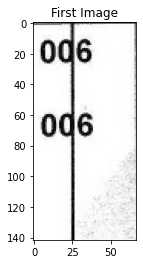

In [39]:
imss=cv2.imread("month.jpg")
results = text_reader.readtext(imss )
textt=[]
for (bbox, text, prob) in results:
    textt.append(text)
easy_res=''.join(textt)
print(textt)
print(easy_res)
plt.imshow(imss)
plt.title("First Image");

In [211]:
36095p14

In [148]:
imss=cv2.imread("D3/ss/water_bill.jpg")
result = bw_scanner(imss)
cv2.imwrite("bbw.jpg",result)

True

In [147]:
cv2.imshow('ss',result)
cv2.waitKey(0)

-1

In [91]:
ocr_strings = ["360950171","","3803501"]
#print('st1:',string1,'st2:',string2,'st3:',string3)
# Calculate the average Levenshtein distance between each OCR string and the other two strings
avg_distances = []
for i in range(len(ocr_strings)):
    total_distance = 0
    for j in range(len(ocr_strings)):
        if i != j:
            total_distance += Levenshtein.distance(ocr_strings[i], ocr_strings[j])
    avg_distance = total_distance / 2
    avg_distances.append(avg_distance)
print(avg_distances)
#if(maxi_letters==True):
print('maxed letters')
ind=unique_long(ocr_strings)
print("indexe :",ind)
if(ind):
    avg_distances[ind]=avg_distances[ind]-2

# Determine the most accurate result based on the average distances
#if min(avg_distances) < 4:
index = avg_distances.index(min(avg_distances))
print(ocr_strings[index])
print(avg_distances)

[6.5, 8.0, 5.5]
maxed letters
indexe : 0
3803501
[6.5, 8.0, 5.5]
